<i>Copyright (c) Microsoft Corporation. All rights reserved.</i>

<i>Licensed under the MIT License.</i>

# Quickstart: Web Cam Image Similarity

Image similarity is the computer vision task of measuring similarity between two images, e.g. to build image retrieval systems. A simple but quite powerful approach is to use the CNNs trained for image classification to represent an image, and to define similarity between two images as the L2 distance between the respective DNN representations.

This is the approach taken in this notebook. More accurate similarity measures are based on DNNs which are trained explicitly for image similarity, such as the [FaceNet](https://arxiv.org/pdf/1503.03832.pdf) work which uses a [Siamese network](https://en.wikipedia.org/wiki/Siamese_network) architecture. 

## Prerequisite for Webcam example 
This notebook assumes you have **a webcam** connected to your machine. We use the `ipywebrtc` module to show the webcam widget in the notebook. Currently, these widgets render correctly on **Chrome** browsers only. For more details about the widget, please visit `ipywebrtc` [github](https://github.com/maartenbreddels/ipywebrtc) or [doc](https://ipywebrtc.readthedocs.io/en/latest/).

## Initialization

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [21]:
import sys
sys.path.append("../..")
import io
import os
from pathlib import Path
import time

import fastai
from fastai.vision import models, open_image, ImageList, cnn_learner #load_learner
from ipywebrtc import CameraStream, ImageRecorder
from ipywidgets import HBox, VBox, Label, Layout, widgets, Widget

from utils_cv.common.data import unzip_url
from utils_cv.common.gpu import which_processor
from utils_cv.classification.data import Urls
from utils_cv.classification.model import model_to_learner
from utils_cv.similarity.metrics import compute_similars
from utils_cv.similarity.model import compute_feature, compute_features
from utils_cv.similarity.plot import plot_similars

print(f"Fast.ai: {fastai.__version__}")
#which_processor()

Fast.ai: 1.0.48


# Image retrieval

We show a simple example of how to build an image retrieval system. Given a *query* image, the goal is to find all similar images in a *reference* set. This is implemented using the following steps:
1. Compute the DNN embeddings for all *reference* images and store in memory.
2. Compute the DNN embedding for the *query* image.
3. Evaluate the L2 distances between the query embedding and all reference embeddings.
4. Return the images with lowest distance or with distance lower than a specified threshold.

Here, we use a pre-trained [ResNet](https://arxiv.org/abs/1512.03385) model using the `fastai.vision` package, alternatively the user can also bring their own trained models. For more details about image classification, including transfer-learning, please see the notebooks in the [classification](../../classification) folder.

## Load images and model
First, we specify the query image and the reference images.

In [20]:
IM_SIZE = 300 #image size in pixels. Reduce to speed-up demo.

# Set path to query and reference images
im_path = unzip_url(Urls.fridge_objects_path, exist_ok=True)
ref_im_path = os.path.join(Path(im_path)/"can")
query_im_path = os.path.join(Path(im_path)/"can"/"1.jpg")
print(f"Query image path = {query_im_path}")
print(f"Reference images directory = {ref_im_path}")

# Construct a DataBunch 
ref_data = (ImageList.from_folder(ref_im_path)
        .split_none()
        .label_from_folder()
        .transform(tfms=None,size=IM_SIZE)
        .databunch(bs=2))

[autoreload of utils_cv.similarity.model failed: Traceback (most recent call last):
  File "C:\anaconda3\envs\cvbp\lib\site-packages\IPython\extensions\autoreload.py", line 244, in check
    superreload(m, reload, self.old_objects)
  File "C:\anaconda3\envs\cvbp\lib\site-packages\IPython\extensions\autoreload.py", line 378, in superreload
    module = reload(module)
  File "C:\anaconda3\envs\cvbp\lib\imp.py", line 315, in reload
    return importlib.reload(module)
  File "C:\anaconda3\envs\cvbp\lib\importlib\__init__.py", line 166, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 618, in _exec
  File "<frozen importlib._bootstrap_external>", line 678, in exec_module
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "../..\utils_cv\similarity\model.py", line 35, in <module>
    featurizer = SaveFeatures(embedding_layer)
NameError: name 'embedding_layer' is not defined
]


Query image path = C:\Users\pabuehle\Desktop\ComputerVision\data\fridgeObjects\can\1.jpg
Reference images directory = C:\Users\pabuehle\Desktop\ComputerVision\data\fridgeObjects\can


Next we load the model

In [4]:
# Load pre-trained model, alternatively one can load a custom model using fastai.vision.load_learner().
learn = cnn_learner(ref_data, models.resnet18, pretrained=True)

## Featurization of reference images
In this section we compute the embedding for each reference image and use the output of the penultimate layer to represent the image. 

In [31]:
# Specify which DNN layer to use as embedding (here: penultimate layer)
embedding_layer = learn.model[1][6]
ref_feature_dict = compute_features(ref_data.train_ds, learn, embedding_layer)
print(f"Computed DNN features for {len(list(ref_feature_dict))} images, each consisting of {len(ref_feature_dict[list(ref_feature_dict)[0]])} floating point values.")

Computed DNN features for 32 images,      each consisting of 512 floating point values.


## Image retrieval from file
First, we load a *query* image and find the most similar images within the *reference* set using the model.

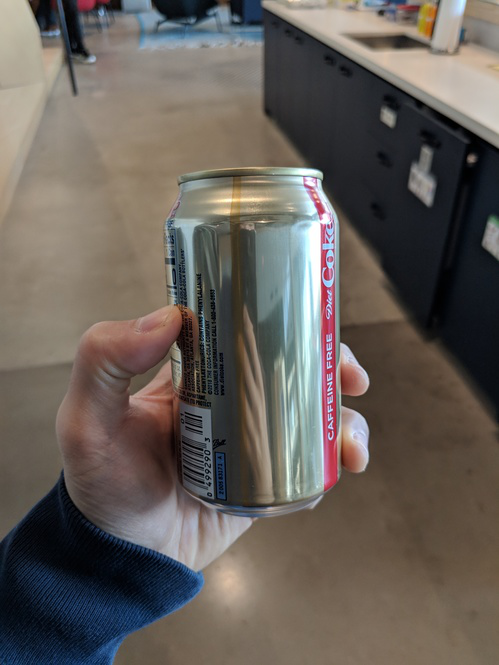

In [8]:
query_im = open_image(query_im_path, convert_mode='RGB')
query_im

In [30]:
# Compute DNN feature for the query image
start_time = time.time()
query_feature = compute_feature(query_im, learn, embedding_layer)
print(f"Computing the DNN representation for the query image took {time.time()-start_time:.4f} sec")

Computing the DNN representation for the query image took 0.3632 sec


Top most similar image with L2 distance of 0.00: C:\Users\pabuehle\Desktop\ComputerVision\data\fridgeObjects\can\1.jpg
Second most similar image with L2 distance of 0.41: C:\Users\pabuehle\Desktop\ComputerVision\data\fridgeObjects\can\3.jpg


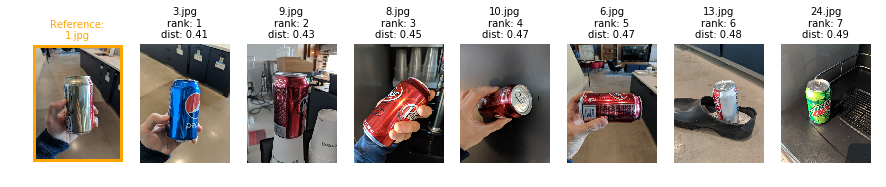

In [17]:
# Compute distance between the query image and all reference images
similars = compute_similars(query_feature, ref_feature_dict)
print(f"Top most similar image with L2 distance of {similars[0][1]:.2f}: {similars[0][0]}")
print(f"Second most similar image with L2 distance of {similars[1][1]:.2f}: {similars[1][0]}")
plot_similars(similars, num_rows=1, num_cols=8, figsize=(15,5))

## Image retrieval from webcam footage

Now, we use a WebCam stream for image retrieval. We use `ipywebrtc` to start a webcam and get the video stream which is sent to the notebook's widget.

In [ ]:
# Webcam
w_cam = CameraStream(
    constraints={
        'facing_mode': 'user',
        'audio': False,
        'video': { 'width': IM_SIZE, 'height': IM_SIZE }
    },
    layout=Layout(width=f'{IM_SIZE}px')
)
# Image recorder for taking a snapshot
w_imrecorder = ImageRecorder(stream=w_cam, layout=Layout(padding='0 0 0 50px'))

# Label widget to show our retrieval results
w_label = Label(layout=Layout(padding='0 0 0 50px'))
w_im = widgets.Image()


def classify_frame(_):
    """ Classify an image snapshot by using a pretrained model
    """
    # Once capturing started, remove the capture widget since we don't need it anymore
    if w_imrecorder.layout.display != 'none':
        w_imrecorder.layout.display = 'none'
        
    try:
        cam_im = open_image(io.BytesIO(w_imrecorder.image.value), convert_mode='RGB')
        
        # Compute DNN representation for the webcam frame
        featurizer.features = None
        _, ind, prob = learn.predict(cam_im)
        query_features = featurizer.features
        
        # Retrieve most similar image among the reference images
        similars = compute_topk_similar(query_features, ref_feature_dict)
        im_path, distance = similars[0]

        # Show result label and confidence
        w_label.value = f"Most similar image with L2 distance of {distance:0.3f}: {im_path}"
        w_im.value = open(im_path, "rb").read()
    except OSError:
        # If im_recorder doesn't have valid image data, skip it. 
        pass
    
    # Taking the next snapshot programmatically
    w_imrecorder.recording = True

# Register classify_frame as a callback. Will be called whenever image.value changes. 
w_imrecorder.image.observe(classify_frame, 'value')

In [ ]:
# Show widgets
VBox([w_label, HBox([w_cam, w_imrecorder, w_im])])

Now, click the **capture button** in the widget to start image retrieval. The most similar reference image is shown along with the distance to the query image given by a webcam frame. Note that some browser either do not render the widget correctly, or do not show the widget at all. In our experience, Chrome seems to be the most reliable.

<center>
<i>Webcam image retrieval example. (left) query webcam image; (right) most similar image.</i>
</center>
<img src="media/image_similarity_webcam.jpg" width="700px" />

# Conclusion
In this notebook, we used a simple example to demonstrate how to use a pretrained model to build an image retrieval system. The model is train on object labels that are part of the ImageNet training samples and hence will only work well for such objects. From our [01_training_and_evaluation_introduction notebook](01_training_and_evaluation_introduction.ipynb), you can find how to fine-tune and customize the model to also perform well for other objects that you may be interested in.

In [ ]:
# Stop the model and webcam
Widget.close_all()